# Классификация при помощи ДПР

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.
1.1 Age, Experience
1.2 ZIP Code
2.1 23.19625
2.2 23.06166


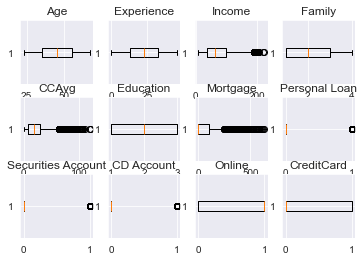

2.3 83
2.4 3917
3.1 0.8671328671328671
3.2 0.8531468531468531
3.3 0.881118881118881
3.4 0.881118881118881
3.5 0.9112671560804341
3.6 2855
3.7 0.8421052631578947
3.8 0.8289473684210527


In [71]:
%pip install imblearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('https://courses.openedu.ru/assets/courseware/v1/0c61cf43490f9189f8ddb65a887dcc64/asset-v1:ITMOUniversity+ADVMLDEEPLEARN+fall_2023_ITMO_mag+type@asset+block/Bank_Personal_Loan_Modelling_train.csv')

# 1. Разведочный анализ данных

df.drop('ID', axis=1, inplace=True)

c = df.corr()
max_corr = 0
max_corr_x = ''
max_corr_y = ''
for i in range(len(df.columns)):
    for j in range(i+1, len(df.columns)):
        if (i == j): continue

        if (c.loc[df.columns[i]][df.columns[j]] > max_corr):
            max_corr = c.loc[df.columns[i]][df.columns[j]]
            max_corr_x = df.columns[i]
            max_corr_y = df.columns[j]

print(f'1.1 {max_corr_x}, {max_corr_y}')
print(f'1.2 {c.abs().sum().idxmin()}')
df.drop(c.abs().sum().idxmin(), axis=1, inplace=True)

# 2. Предварительная подготовка данных
# Модификация признаков
df['Experience'] -= df['Experience'].min()
print(f'2.1 {df["Experience"].mean()}')
df['CCAvg'] *= 12
print(f'2.2 {df["CCAvg"].mean()}')

# Определение выбросов
fig, axs = plt.subplots(3, 4)

for i, col in enumerate(df.columns):
    ax = axs[i // 4][i % 4]
    ax.boxplot(df[col], vert=False)
    ax.set_title(col)

plt.show()

# Для 2.3 2.4 по графику можно сделать
# 2.3 тупо смотрите какой больше похож
# 2.4 максимально растяните окно, и смотрите у кого больше точек.
# У меня в 2.4 mortgage
print('2.5', (zscore(df['Mortgage']) > 3).sum())
df = df[~(zscore(df['Mortgage']) > 3)]
print('2.6', len(df))

# 3. Построение моделей
# Базовый алгоритм
x = df.drop('Personal Loan', axis=1)
y = df['Personal Loan']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=27, stratify=y)
tree = DecisionTreeClassifier(random_state=27, criterion='gini')
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print('3.1', f1_score(y_test, y_pred))

tree = DecisionTreeClassifier(random_state=27, criterion='entropy')
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print('3.2', f1_score(y_test, y_pred))

tree = DecisionTreeClassifier(random_state=27, criterion='gini', class_weight='balanced')
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print('3.3', f1_score(y_test, y_pred))

tree = DecisionTreeClassifier(random_state=27, criterion='entropy', class_weight='balanced')
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print('3.4', f1_score(y_test, y_pred))

# Upsampling обучающей выборки

print('3.5', y_train.value_counts()[0] / len(y_train))

smote = SMOTE(random_state=27)
x_train, y_train = smote.fit_resample(x_train, y_train)
print('3.6', y_train.value_counts()[1])

tree = DecisionTreeClassifier(random_state=27, criterion='gini')
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print('3.7', f1_score(y_test, y_pred))

tree = DecisionTreeClassifier(random_state=27, criterion='entropy')
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print('3.8', f1_score(y_test, y_pred))

# Описание набора данных

В этой лабораторной работе мы рассмотрим разные подходы к задаче классификации, в частности, деревья принятия решений, а также поговорим о том, как бороться с несбалансированностью датасета.

Изучаемый нами набор данных — это набор данных о принятых предложениях по кредитам в банке **Thera-Bank**. Основные клиенты банка пользуются банком для того, чтобы разместить в нем свои денежные средства, то есть являются вкладчиками. В то же время, большую прибыль банку приносят кредиторы — люди, берущие в банке кредит. Поэтому банк хочет сформировать для своих вкладчиков выгодные предложения по кредиту. Кампания, проведенная банком для вкладчиков в прошлом году, показала, что коэффициент конверсии составил более 9,6%. Это побудило отдел маркетинга разработать кампании с улучшенным целевым маркетингом, чтобы увеличить вероятность успеха при, естественно, минимальном бюджете. Департамент хотел бы разработать классификатор, который поможет им определить потенциальных клиентов, которые с большей вероятностью приобретут кредит. Это повысит вероятность успеха при одновременном снижении стоимости кампании.

Набор данных содержит как информацию о клиенте, так и информацию о его реакции на кампанию предыдущего года:

*   **ID**: ID клиента

*   **Age**: Возраст (полных лет)

*   **Experience**: Стаж

*   **Income**: Годовой доход (в тысячах)

*   **Zipcode**: Индекс места проживания

*   **Family**: Количество членов семьи

*   **CCAvg**: Средние траты в месяц по кредитной карте (в тысячах)

*   **Education**: Уровень образования (1: бакалавр, 2: магистр, 3: что-то большее)

*   **Mortgage**: Стоимость ипотеки, если имеется (в тысячах)

*   **Securities Account**: Наличие счета в ценных бумагах

*   **CD Accoun**t: Наличие сертификата на депозит

*   **Online**: Использует ли клиент интернет-банкинг

*   **CreditCard**: Использует ли клиент кредитную карту, выпущенную данным банком

*   **Personal Loan**: Принял ли клиент персональное предложение по кредиту (целевая переменная)

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [72]:
import pandas as pd 
import numpy as np
df = pd.read_csv('https://courses.openedu.ru/assets/courseware/v1/dddc0dd9f40894c81c3d3685d3a74f9d/asset-v1:ITMOUniversity+ADVMLDEEPLEARN+fall_2023_ITMO_mag+type@asset+block/Bank_Personal_Loan_Modelling_reserved.csv')

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [73]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2511.770000,44.974000,19.738000,74.952000,93136.180000,2.455000,2.002470,1.879000,58.621000,0.106000,0.056000,0.588000,0.308000
std,1419.093565,11.356685,11.336572,44.868239,1787.128983,1.138099,1.781398,0.831294,104.332395,0.307992,0.230037,0.492441,0.461898
min,5.000000,23.000000,-2.000000,8.000000,90007.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1277.500000,35.000000,10.000000,41.000000,91908.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2554.000000,45.000000,20.000000,65.000000,93555.000000,2.000000,1.700000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3696.750000,55.000000,29.000000,101.000000,94608.000000,4.000000,2.600000,3.000000,103.000000,0.000000,0.000000,1.000000,1.000000
max,4995.000000,67.000000,42.000000,205.000000,96150.000000,4.000000,9.000000,3.000000,590.000000,1.000000,1.000000,1.000000,1.000000


Набор данных содержит 14 переменных, 1 из которых является целевой.

1 номинальная переменная: **ID**

5 числовых переменных: **Age**, **Experience**, **Income**, **CC_Avg**, **Mortgage**

3 категориальные переменных: **Family**, **Education**, **Zip_Code**

5 булевых переменных: **Personal_Loan**, **Securities Account**, **CD Account**, **Online**, **CreditCard**

Пропущенных значений нет.

Experience содержит какие-то отрицательные значения

Удалите колонку ID, она нам не понадобится

In [74]:
df.drop('ID',axis=1,inplace=True)

Имеет смысл попробовать отловить каике-либо зависимости или их отсутствие.

Постройте матрицу корреляций

<Axes: >

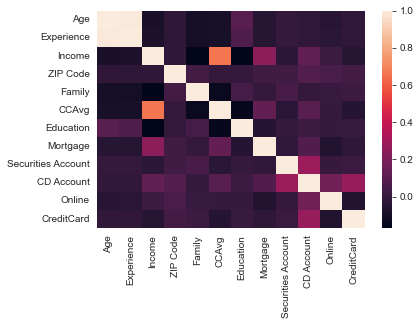

In [75]:
import seaborn as sns 
sns.heatmap(df.corr())

In [76]:
df.corr()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
Age,1.000000,0.994542,-0.087012,-0.021298,-0.095815,-0.094879,0.098062,-0.047322,-0.005793,-0.017451,-0.041832,-0.016791
Experience,0.994542,1.000000,-0.081614,-0.023373,-0.101619,-0.094766,0.072897,-0.048645,-0.006946,-0.016247,-0.039617,-0.017645
Income,-0.087012,-0.081614,1.000000,-0.020207,-0.164489,0.663867,-0.168695,0.245410,-0.034328,0.127988,0.018857,-0.047876
ZIP Code,-0.021298,-0.023373,-0.020207,1.000000,0.040767,-0.008338,-0.006107,0.027870,0.031064,0.081119,0.058814,0.038586
Family,-0.095815,-0.101619,-0.164489,0.040767,1.000000,-0.134115,0.042380,-0.007162,0.053602,-0.005659,0.006180,0.014967
CCAvg,-0.094879,-0.094766,0.663867,-0.008338,-0.134115,1.000000,-0.147143,0.129451,-0.036894,0.102257,-0.002388,-0.050329
Education,0.098062,0.072897,-0.168695,-0.006107,0.042380,-0.147143,1.000000,-0.052512,-0.000680,0.019766,-0.002083,0.008520
Mortgage,-0.047322,-0.048645,0.245410,0.027870,-0.007162,0.129451,-0.052512,1.000000,-0.017346,0.073415,-0.059485,-0.025181
Securities Account,-0.005793,-0.006946,-0.034328,0.031064,0.053602,-0.036894,-0.000680,-0.017346,1.000000,0.283476,0.004435,0.009513
CD Account,-0.017451,-0.016247,0.127988,0.081119,-0.005659,0.102257,0.019766,0.073415,0.283476,1.000000,0.168531,0.270869


Определите две наиболее коррелированных переменных

In [77]:
df.drop('ZIP Code',axis=1,inplace=True)

Определите признак, который меньше всего коррелирует (можно считать почти не коррелирует) с остальными признаками (в том числе с откликом). Удалите этот признак из рассмотрения.

Введите название удаленного признака.

In [78]:
# < ENTER YOUR CODE HERE > 

# Предварительная подготовка данных

## Модификация признаков

Стоит разобраться с полем <code>Experience</code>. Видно, что опыт коррелирует с возрастом. Однако, в поле <code>Experience</code> присутствуют отрицательные значения. Имеет смысл "сдвинуть" значения в этой колонке. Добавьте ко всем значениям колонки <code>Experience</code> одно число так, чтобы минимальное значение было равно $0$.

Вычислите выборочное среднее колонки <code>Experience</code> после преобразования.

In [79]:
m = -df['Experience'].min()
df['Experience']= df['Experience'].to_numpy()+m


In [80]:
df['Experience'].mean()

21.738

Аналогично имеет смысл модфицировать поле <code>CCAvg</code>. Раз рассматривается годовой доход, то имеет смысл и значения трат рассматривать в рамках года.

Вычислите выборочное среднее колонки <code>CCAvg</code> после преобразования.

In [81]:
df['CCAvg']= df['CCAvg'].to_numpy()*12
df['CCAvg'].mean()


24.02964

## Определение выбросов

Постройте ящики с усами для всех предикторов. Рекомендуем использовать <code>sns.boxplot()</code>. Определите признак по изображению boxplot из вашего варианта.

<Axes: >

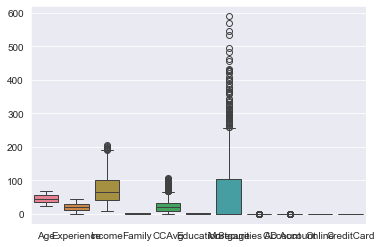

In [82]:
sns.boxplot(df)

Определите признак, содержащий наибольшее число выбросов. Введите название этого признака.


<Axes: xlabel='Mortgage', ylabel='Count'>

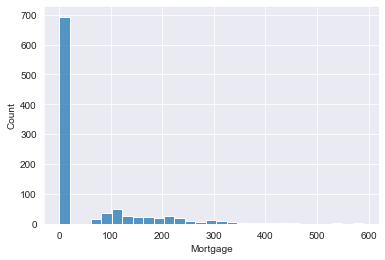

In [83]:
sns.histplot(df['Mortgage'])

Имеет смысл поработать с этим признаком, а для этого стоит руководствоваться следующими статистическими соображениями. Если вычесть из данных выборочное среднее, а после поделить на среднеквадратическое отклонение, то, пользуясь правилом 3-$\sigma$ для нормального распределения, можно выбросить слишком далекие от нуля хвосты. Постройте гистограмму распределения значений в рамках этого признака.

In [84]:
# < ENTER YOUR CODE HERE > 

Очевидно в рамках этого признака есть небольшое количество значений, которые лежат далеко. Можно использовать <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html"><code>z-score</code></a> функцию из библиотеки <code>scipy</code>. 

Вспомнив курс теории вероятностей, становится понятно, что около $99.7\%$ нормального распределения сождержатся в отрезке $[-3\sigma, 3\sigma]$. Определите число элементов, модуль <code>z-score</code> которых больше, чем $3$. 

In [85]:
# < ENTER YOUR CODE HERE > 

Итак, выбросов не очень множко, поэтому выбросите их из набора данных. Введите оставшееся в датасете число строк.

In [86]:
# < ENTER YOUR CODE HERE > 

# Построение моделей

# Базовый алгоритм

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [87]:
# < ENTER YOUR CODE HERE > 

Обучите модель <code>DecisionTreeClassifier</code> с параметрами, указанными в вашем варианте на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score</code> модели на тестовых данных.

In [88]:
# < ENTER YOUR CODE HERE > 

## Учет дисбаланса соотношения классов

А теперь, если вспомнить, что выборка несбалансирована, то можно указать дополнительный параметр <code>class_weight</code>. Обучите модель <code>DecisionTreeClassifier</code> с параметрами, указанными в вашем варианте на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score</code> модели на тестовых данных.

In [89]:
# < ENTER YOUR CODE HERE > 

## Upsampling обучающей выборки

Помимо очевидного присвоения весов несбалансированным классам, можно воспользоваться алгоритмом <code>SMOTE</code>. Ему на вход подаются экземпляры всех классов с их метками, а он в свою очередь пытается на их основе экстраполировать само распределение данных этого класса. После этого он сэмплирует новые объекты классов так, пока количество строк каждого класса не станет везде одинаковым.

Получается, что в таком случае будет получена сбалансированная выборка, и пропадет нужда как-то ухищряться с весами и прочим. 

Определите долю элементов класса $0$ тренировочного набора данных.

In [90]:
# < ENTER YOUR CODE HERE > 

Используя класс <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html"><code>SMOTE</code></a> из модуля <code>imblearn.over_sampling</code> сбалансируйте обучающую выборку с параметрами, указанными в вашем варианте.

In [91]:
# < ENTER YOUR CODE HERE > 

Убедитесь, что теперь в выборке содержится одинаковое число представителей обоих классов. Введите количество объектов класса $1$.

In [92]:
# < ENTER YOUR CODE HERE > 

Снова обучите модель <code>DecisionTreeClassifier</code> с параметрами, указанными в вашем варианте на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score</code> модели на тестовых данных.

In [93]:
# < ENTER YOUR CODE HERE > 